In [2]:
import numpy as np
from pathlib import Path
from natsort import natsorted
import cv2 as cv
from numba import njit
import cupy as cp
import time

In [3]:
def image_normalization(image: np.ndarray) -> np.ndarray:
    vmin, vmax = np.percentile(image, [1, 99])
    image = np.clip(image, vmin, vmax)
    image = image - image.min()
    image = (image - image.min()) * (255 / (image.max() - image.min()))
    image = image.astype(np.uint8)
    return image

In [4]:
paths2ct = natsorted(Path('/home/artur/hppl/80kV').glob('*.tif'))
ct_img_0 = cv.imread(str(paths2ct[0]), cv.IMREAD_UNCHANGED)

In [5]:
print(ct_img_0.shape, len(paths2ct))

(2014, 2014) 71


In [5]:
import scipy

In [6]:
def create_voxels():
    ct_voxels = np.empty((ct_img_0.shape[0], ct_img_0.shape[1] , len(paths2ct)), dtype = np.uint8)
    for i in range(ct_voxels.shape[2]):
        ct_slice = cv.imread(str(paths2ct[i]), cv.IMREAD_UNCHANGED)
        ct_slice = image_normalization(ct_slice)
        # kernel size = int(truncate * sigma + 0.5)
        ct_voxels[:, :, i] = scipy.ndimage.gaussian_filter(ct_slice, 0.5, 3)  # size = 3*0.5 + 0.5 = 2


In [7]:
np_time = %timeit -o create_voxels()
np_time.best

6.26 s ± 50.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


6.227324551999999

In [8]:
nb_create_voxels = njit()(create_voxels)

In [9]:
nb_time = %timeit -o create_voxels()
nb_time.best

6.19 s ± 6.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


6.188419685000014

In [10]:
nb_time.best / np_time.best

0.9937525551020959

In [11]:
def cp_image_normalization(image):
    vmin, vmax = cp.percentile(image, [1, 99])
    image = cp.clip(image, vmin, vmax)
    image = image - image.min()
    image = (image - image.min()) * (255 / (image.max() - image.min()))
    image = image.astype(cp.uint8)
    return image

In [12]:
from cupyx.scipy.ndimage import gaussian_filter

In [13]:
def cp_create_voxels2D():
    ct_voxels = cp.empty((ct_img_0.shape[0], ct_img_0.shape[1] , len(paths2ct)), dtype = cp.uint8)
    for i in range(ct_voxels.shape[2]):
        ct_slice = cp.asarray(cv.imread(str(paths2ct[i]), cv.IMREAD_UNCHANGED))
        ct_slice = cp_image_normalization(ct_slice)
        ct_voxels[:, :, i] = gaussian_filter(ct_slice, 0.5, 3)

In [14]:
cp_time2D = %timeit -o cp_create_voxels2D()
cp_time2D.best

1.59 s ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


1.5911526239999887

In [15]:
np_time.best / cp_time2D.best

3.9137191857467237

In [16]:
def cp_create_voxels3D():
    ct_voxels = cp.empty((ct_img_0.shape[0], ct_img_0.shape[1] , len(paths2ct)), dtype = cp.uint8)
    for i in range(ct_voxels.shape[2]):
        ct_slice = cp.asarray(cv.imread(str(paths2ct[i]), cv.IMREAD_UNCHANGED))
        ct_voxels[:, :, i] = cp_image_normalization(ct_slice)
    ct_voxels = gaussian_filter(ct_voxels, 0.5, 3)

In [17]:
cp_time3D = %timeit -o cp_create_voxels3D()
cp_time3D.best

1.64 s ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


1.5614436440000077

In [18]:
cp_time2D.best, cp_time3D.best

(1.5911526239999887, 1.5614436440000077)

In [19]:
from gputools.convolve import gaussian_filter as gputool_gaussian_filter

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


In [20]:
def gputool_create_voxels3D():
    ct_voxels = cp.empty((ct_img_0.shape[0], ct_img_0.shape[1] , len(paths2ct)), dtype = cp.uint8)
    for i in range(ct_voxels.shape[2]):
        ct_slice = cp.asarray(cv.imread(str(paths2ct[i]), cv.IMREAD_UNCHANGED))
        ct_voxels[:, :, i] = cp_image_normalization(ct_slice)
    
    ct_voxels = gputool_gaussian_filter(ct_voxels.get(), 2)

In [21]:
gputool_time3D = %timeit -o gputool_create_voxels3D()
gputool_time3D.best

1.8 s ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


1.7974883769999792

In [22]:
gputool_time3D.best, cp_time3D.best

(1.7974883769999792, 1.5614436440000077)

In [10]:
from dask_image.imread import imread
from dask_image import ndfilters

In [11]:
ct_images = imread('/home/artur/hppl/80kV/*.tif')[:2]
ct_images

dask.array<getitem, shape=(2, 2014, 2014), dtype=uint16, chunksize=(1, 2014, 2014), chunktype=numpy.ndarray>

In [25]:
def daskcpu_create_voxels3D():
    ct_images = imread('/home/artur/hppl/80kV/*.tif')
    ct_images_smootheed = ndfilters.gaussian_filter(ct_images, 0.5, 3)

In [26]:
dask_time3D = %timeit -o daskcpu_create_voxels3D()
dask_time3D.best

4.21 ms ± 47.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0.004167646440000112

In [27]:
cp_time3D.best / dask_time3D.best

374.6583752915388

In [28]:
def daskgpu_create_voxels3D():
    ct_images_gpu = imread('/home/artur/hppl/80kV/*.tif', arraytype="cupy")
    ct_images_smootheed = ndfilters.gaussian_filter(ct_images_gpu, 0.5, 3)

In [29]:
dask_time3D = %timeit -o daskgpu_create_voxels3D()
dask_time3D.best

3.91 ms ± 45.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0.003865939920000301

In [6]:
from cucim.skimage.segmentation import random_walker

In [7]:
def segmentation(Thresh_1, Thresh_2, file):
    Base1 = cp.empty_like(file)
    Base2 = cp.empty_like(file)
    Base3 = cp.empty_like(file)
    Lx, Ly, Lz = Base1.shape
    for i in range(Lx):
        slice = file[i, ...]
        markers = cp.zeros([Ly, Lz], dtype=file.dtype)
        markers[slice < Thresh_1] = 1
        markers[slice > Thresh_2] = 2
        labels = random_walker(slice, markers, beta=1, mode='bf')
        Base1[i, :, :] = labels

    for i in range(Ly):
        slice = file[:, i, ...]
        markers = cp.zeros([Lx, Lz], dtype = file.dtype)
        markers[slice < Thresh_1] = 1
        markers[slice > Thresh_2] = 2
        labels = random_walker(slice, markers, beta=1, mode='bf')
        Base2[:, i, :] = labels

    for i in range(Lz):
        slice = file[..., i]
        markers = cp.zeros([Lx, Ly], dtype= file.dtype)
        markers[slice < Thresh_1] = 1
        markers[slice > Thresh_2] = 2
        labels = random_walker(slice, markers, beta=1, mode='bf')
        Base3[:, :, i] = labels

    Base = cp.median(cp.stack([Base1, Base2, Base3]), axis = 0)

    Base[Base == 2] = 255
    Base[Base == 1] = 0
    return Base

In [10]:
ct_voxels = np.empty((300, 300 , 2), dtype = np.uint8)
for i in range(2):
    ct_slice = cv.imread(str(paths2ct[i]), cv.IMREAD_UNCHANGED)[1200:1500, 1200:1500]
    ct_slice = image_normalization(ct_slice)
    ct_voxels[:, :, i] = ct_slice  

In [23]:
result = segmentation(50, 120, cp.asarray(ct_voxels))

In [18]:
imgs = result.get()

In [19]:
imgs.shape

(300, 300, 2)

In [12]:
import matplotlib.pyplot as plt

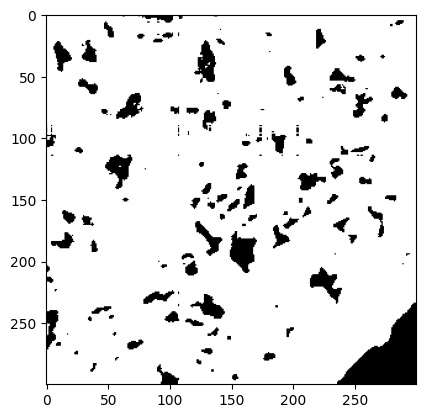

In [21]:
plt.imshow(imgs[:, :, 0], 'gray')

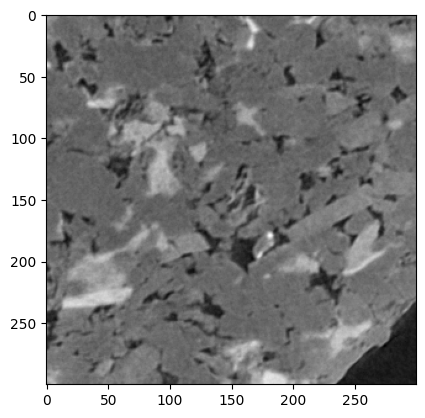

In [22]:
original_img = cv.imread(str(paths2ct[0]), cv.IMREAD_UNCHANGED)[1200:1500, 1200:1500]
plt.imshow(original_img , 'gray')